# Text classification

In [116]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/computational_ml_2/computing/neuralNets/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/computational_ml_2/computing/neuralNets/'
/content/drive/MyDrive/computational_ml_2/computing/neuralNets


In [117]:
# Import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Activation, Dense, Dropout, Embedding,
    Flatten, Input, Convolution1D, MaxPooling1D,
    concatenate, LSTM, SimpleRNN, GRU
)
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import os
import pickle
from w2v import train_word2vec

np.random.seed(2)

# Load and preprocess data

In [118]:
embedding_dim = 50
max_sequence_length = 56
max_sequence_length_char = 148

In [119]:
# Load data
dt = pd.read_csv(
    os.path.join("data/data.txt"), sep="\t", header=None,
    names=["text", "labels"]
)

- Not necessary to remove stop words, but perhaps still useful to remove punctuation

In [120]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace('.',' ')
    text = text.replace(',',' ')
    text = text.replace('-',' ')
    text = text.replace('%','')
    text = text.replace(':',' ')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace('\n',' ')
    text = text.replace('[',' ')
    text = text.replace(']',' ')
    text = text.replace('"',' ')
    text = text.replace('  ',' ')
    
    return text

In [121]:
texts = list(map(lambda x: preprocess_text(x), dt.text)) # preprocess
labels = list(dt.labels)

Now we need turn our text samples and labels into tensors that can be fed into a neural network.

In [122]:
# Word-wise:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens (words).' % len(word_index))

# Character-wise:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(texts)
sequences_char = tokenizer.texts_to_sequences(texts)

char_index = tokenizer.word_index
print('Found %s unique tokens (characters).' % len(char_index))

Found 2071 unique tokens (words).
Found 48 unique tokens (characters).


With the text now tokenized we can use `pad_sequences` to turn the sentences/texts into numerical sequences:

In [123]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
data_char = pad_sequences(sequences_char, maxlen=max_sequence_length_char)

We'll also rearrange the labels slightly:

In [124]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(labels))

Now both the text data and labels are in an adequate format to be passed to a neural network:

In [125]:
print('Shape of data tensor (words):', data.shape)
print('Shape of data tensor (characters):', data_char.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor (words): (1000, 56)
Shape of data tensor (characters): (1000, 148)
Shape of label tensor: (1000, 2)


## Embeddings

### Pre-trained embeddings - GloVe

Our sample is very small so instead of learning the embeddings from our sample it may be useful to use pre-trained embeddings. For starters we will rely on the smallest global vector embedding available from [GloVe](https://nlp.stanford.edu/projects/glove/), which is still considerable larger than any reasonable embedding we could learn form our sample.

Below we read the 50-$d$ embedding and store dictionary `embeddings_index` containing all words (keys) and their corresponding word vector (values).

In [126]:
GLOVE_DIR = "data/glove/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Now we can use the dictionary of words in our sample created earlier (`word_index`) and match them with their global word vectors if available in `embeddings_index`:

In [127]:
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
no_wv_available = []
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
  else:
    no_wv_available.append(word)

We can see that the the shape of the embedding tensor is in line with the sample as expected. For about 5% of the words in our sample we do not have a corresponding word vector.

In [128]:
print('Shape of embedding tensor:', embedding_matrix.shape)
print('No word vectors available for %i out of %i words.' % (len(no_wv_available), len(word_index)))

Shape of embedding tensor: (2072, 50)
No word vectors available for 101 out of 2071 words.


### Visualizing the word vectors

To get a better understanding of our embedded text, we can register the word vectors in a 2-dimensional subspace and  visualise them.

In [129]:
from matplotlib import pylab
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)
# get the T-SNE manifold
two_d_embeddings = tsne.fit_transform(embedding_matrix)

In fact it appears that related words appear close too each other and/or on the same line.

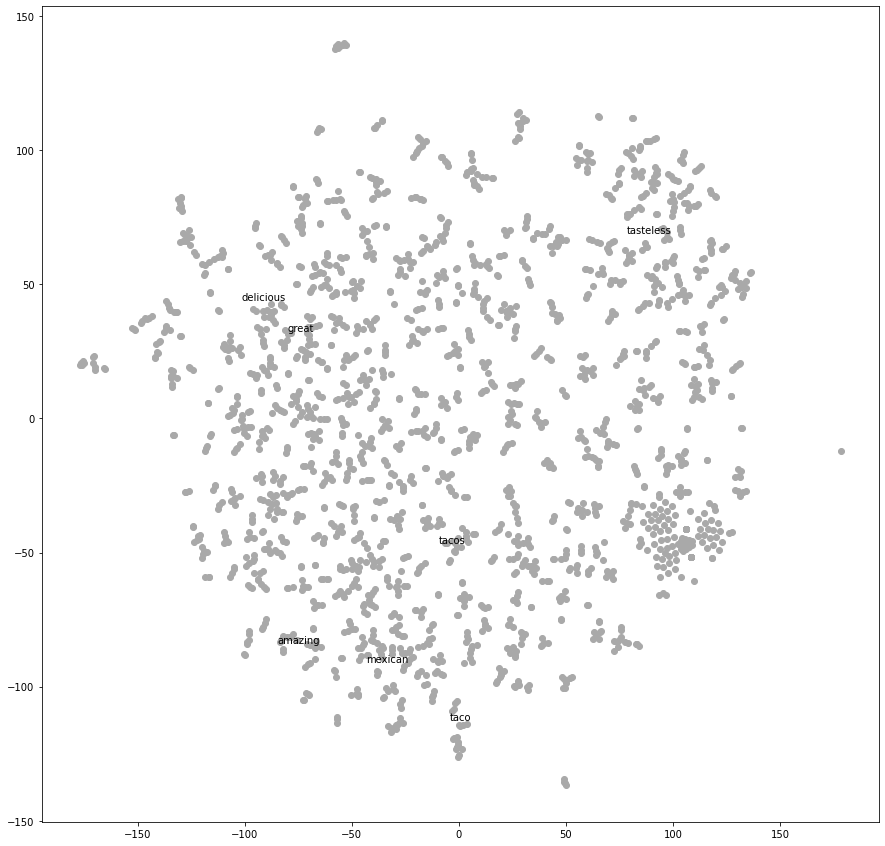

In [130]:
suggested_words = ['delicious', 'amazing', 'great',
                   'tasteless', 'digust',
                   'tacos', 'taco', 'mexican']
all_words = list(word_index.keys())
selected_words = [i for i in suggested_words if i in all_words]

pylab.figure(figsize=(15,15))
# plot all the embeddings and their corresponding words
for i, label in enumerate(all_words):
  x, y = two_d_embeddings[i,:]
  pylab.scatter(x, y, c='darkgray')   
  if label in selected_words:
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                    ha='right', va='bottom',fontsize=10)
        
pylab.show()

# A first run

In this section we will have a first go at the text classification task. We will first attempt the word-wise implementation follows by the character-wise implementation.

## Word-wise

In [131]:
# Model hyper parameters:
filter_sizes = (3, 4)
num_filters = 150
dropout_prob = (0.25, 0.5)
hidden_dims = 150
# Training parameters:
batch_size = 32
num_epochs = 10
val_split = 0.1
# Word2Vec parameters, see train_word2vec
min_word_count = 1  # Minimum word count                        
context = 10        # Context window size  

#### CNN

We retrieve the data:

In [132]:
# Shuffle data
x = data
vocabulary_inv = ['<PAD/>'] + list(word_index.keys())
y = labels
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices].argmax(axis=1)
texts_shuffled = [texts[i] for i in list(shuffle_indices)]
labels_shuffled = [dt.labels[i] for i in list(shuffle_indices)]

We form the embedding layer:

In [133]:
# Embedding:
model_variation = 'glove'
embedding_weights = {
    'glove': [embedding_matrix],
    'non-static': train_word2vec(
        x, vocabulary_inv,
        embedding_dim, min_word_count, 
        context
    ),
    'rand': None
}

embedding_layer = Embedding(
    len(word_index)+1,
    embedding_dim,
    weights=embedding_weights[model_variation],
    input_length=max_sequence_length
)

Loading existing Word2Vec model '50features_1minwords_10context'


We build the model:

In [134]:
graph_in = Input(shape=(max_sequence_length,embedding_dim))

convs = [] # list of flattened convolutions to be passed into network
for fsz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in)
    pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
    flatten = Flatten()(pool) # take output of convolution and flatten it
    convs.append(flatten)
    
if len(filter_sizes)>1:
    out = concatenate(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out)

# main sequential model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout_prob[0], input_shape=(max_sequence_length,embedding_dim)))
model.add(graph)
model.add(Dense(hidden_dims))
model.add(Dropout(dropout_prob[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid')) # link function

Finally, we compile and run the model. Both in-sample and validation accuracy after 10 epochs are fair, though there seems to be room for improvement.

In [135]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 2s - loss: 0.8015 - accuracy: 0.5256 - val_loss: 0.6255 - val_accuracy: 0.7400
Epoch 2/10
29/29 - 1s - loss: 0.6320 - accuracy: 0.6411 - val_loss: 0.5574 - val_accuracy: 0.7000
Epoch 3/10
29/29 - 1s - loss: 0.5513 - accuracy: 0.7289 - val_loss: 0.4914 - val_accuracy: 0.7700
Epoch 4/10
29/29 - 1s - loss: 0.4826 - accuracy: 0.7656 - val_loss: 0.4381 - val_accuracy: 0.8200
Epoch 5/10
29/29 - 1s - loss: 0.3899 - accuracy: 0.8256 - val_loss: 0.4145 - val_accuracy: 0.8300
Epoch 6/10
29/29 - 1s - loss: 0.3468 - accuracy: 0.8422 - val_loss: 0.5063 - val_accuracy: 0.7500
Epoch 7/10
29/29 - 1s - loss: 0.2649 - accuracy: 0.8911 - val_loss: 0.4164 - val_accuracy: 0.8400
Epoch 8/10
29/29 - 1s - loss: 0.2778 - accuracy: 0.8900 - val_loss: 0.5465 - val_accuracy: 0.7200
Epoch 9/10
29/29 - 1s - loss: 0.2284 - accuracy: 0.9122 - val_loss: 0.3913 - val_accuracy: 0.8200
Epoch 10/10
29/29 - 1s - loss: 0.1728 - accuracy: 0.9356 - val_loss: 0.5935 - val_accuracy: 0.7800


Let's have a quick look at a few sample predictions below:

In [136]:
slice = 10
predicted = model.predict(x_shuffled[:slice])
pd.DataFrame({"sentence": texts_shuffled[:slice],"true": labels_shuffled[:slice], "pred": predicted.flatten()})

,sentence,true,pred
0,first time going but i think i will quickly be...,1,0.842042
1,today was my first taste of a buldogis gourmet...,1,0.998429
2,this is some seriously good pizza and i'm an e...,1,0.994999
3,this is the place where i first had pho and it...,1,0.997561
4,the manager was the worst,0,0.030356
5,everyone is treated equally special,1,0.952296
6,i will not be eating there again,0,0.112665
7,don't bother coming here,0,0.060316
8,if the food isn't bad enough for you then enjo...,0,0.006166
9,it was equally awful,0,0.087148


### RNN

Now let's run a simple LSTM. The results here look somewhat better than for the convolutional network, but since we have not fine tuned yet, it is too early to draw any conclusions as to which approach performs better.

In [137]:
# create the model 
model = Sequential() 
model.add(embedding_layer) 
model.add(LSTM(100)) 
model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

In [138]:
# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 4s - loss: 0.6153 - accuracy: 0.6689 - val_loss: 0.5276 - val_accuracy: 0.7700
Epoch 2/10
29/29 - 2s - loss: 0.4534 - accuracy: 0.8122 - val_loss: 0.4574 - val_accuracy: 0.7800
Epoch 3/10
29/29 - 2s - loss: 0.3311 - accuracy: 0.8844 - val_loss: 0.4413 - val_accuracy: 0.8000
Epoch 4/10
29/29 - 2s - loss: 0.2708 - accuracy: 0.9044 - val_loss: 0.4930 - val_accuracy: 0.7700
Epoch 5/10
29/29 - 2s - loss: 0.2012 - accuracy: 0.9356 - val_loss: 0.6100 - val_accuracy: 0.7600
Epoch 6/10
29/29 - 2s - loss: 0.1744 - accuracy: 0.9467 - val_loss: 0.6149 - val_accuracy: 0.7600
Epoch 7/10
29/29 - 2s - loss: 0.1472 - accuracy: 0.9522 - val_loss: 0.6142 - val_accuracy: 0.7700
Epoch 8/10
29/29 - 2s - loss: 0.1327 - accuracy: 0.9600 - val_loss: 0.5586 - val_accuracy: 0.7800
Epoch 9/10
29/29 - 2s - loss: 0.0966 - accuracy: 0.9733 - val_loss: 0.5684 - val_accuracy: 0.8000
Epoch 10/10
29/29 - 2s - loss: 0.0955 - accuracy: 0.9700 - val_loss: 0.6313 - val_accuracy: 0.8000


Once agains, let us look at a few sample predictions:

In [139]:
slice = 10
predicted = model.predict(x_shuffled[:slice])
pd.DataFrame({"sentence": texts_shuffled[:slice],"true": labels_shuffled[:slice], "pred": predicted.flatten()})

,sentence,true,pred
0,first time going but i think i will quickly be...,1,0.992720
1,today was my first taste of a buldogis gourmet...,1,0.990164
2,this is some seriously good pizza and i'm an e...,1,0.994482
3,this is the place where i first had pho and it...,1,0.998131
4,the manager was the worst,0,0.013074
5,everyone is treated equally special,1,0.929604
6,i will not be eating there again,0,0.005547
7,don't bother coming here,0,0.015950
8,if the food isn't bad enough for you then enjo...,0,0.000632
9,it was equally awful,0,0.045196


## Character-wise

Below follows the character-wise implementation. I will avoide detailed comments to avoid repetition and only state the high-level results here:

- Both the CNN and RNN perform poorly compared to the word-wise implementation.
- The CNN achieve better in-sample accuracy, but validation accuracy is roughly the same for both models.

### CNN

In [140]:
# Shuffle data
x = data_char
vocabulary_inv = ['<PAD/>'] + list(char_index.keys())
y = labels
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices].argmax(axis=1)

In [141]:
# Embedding:
model_variation = 'rand'
embedding_weights = {
    'non-static': train_word2vec(
        x, vocabulary_inv,
        embedding_dim, min_word_count, 
        context
    ),
    'rand': None
}

embedding_layer = Embedding(
    len(char_index)+1,
    embedding_dim,
    weights=embedding_weights[model_variation],
    input_length=max_sequence_length_char
)

Loading existing Word2Vec model '50features_1minwords_10context'


In [142]:
graph_in = Input(shape=(max_sequence_length_char,embedding_dim))

convs = [] # list of flattened convolutions to be passed into network
for fsz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in)
    pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
    flatten = Flatten()(pool) # take output of convolution and flatten it
    convs.append(flatten)
    
if len(filter_sizes)>1:
    out = concatenate(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out)

# main sequential model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout_prob[0], input_shape=(max_sequence_length_char,embedding_dim)))
model.add(graph)
model.add(Dense(hidden_dims))
model.add(Dropout(dropout_prob[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid')) # link function

In [143]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 4s - loss: 0.7255 - accuracy: 0.5333 - val_loss: 0.6868 - val_accuracy: 0.5400
Epoch 2/10
29/29 - 3s - loss: 0.6723 - accuracy: 0.5822 - val_loss: 0.6894 - val_accuracy: 0.5800
Epoch 3/10
29/29 - 3s - loss: 0.6303 - accuracy: 0.6689 - val_loss: 0.6690 - val_accuracy: 0.6100
Epoch 4/10
29/29 - 3s - loss: 0.5589 - accuracy: 0.7211 - val_loss: 0.6682 - val_accuracy: 0.6100
Epoch 5/10
29/29 - 3s - loss: 0.4923 - accuracy: 0.7833 - val_loss: 0.6604 - val_accuracy: 0.6100
Epoch 6/10
29/29 - 3s - loss: 0.4170 - accuracy: 0.8144 - val_loss: 0.7168 - val_accuracy: 0.6100
Epoch 7/10
29/29 - 3s - loss: 0.3748 - accuracy: 0.8322 - val_loss: 0.8263 - val_accuracy: 0.5900
Epoch 8/10
29/29 - 3s - loss: 0.2880 - accuracy: 0.8844 - val_loss: 1.2487 - val_accuracy: 0.5600
Epoch 9/10
29/29 - 3s - loss: 0.2660 - accuracy: 0.8967 - val_loss: 0.8633 - val_accuracy: 0.6000
Epoch 10/10
29/29 - 3s - loss: 0.2178 - accuracy: 0.9222 - val_loss: 0.8326 - val_accuracy: 0.6100


### RNN

In [144]:
# create the model 
embedding_vector_length = 32 
model = Sequential() 
model.add(embedding_layer) 
model.add(LSTM(100)) 
model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

In [145]:
# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 7s - loss: 0.6887 - accuracy: 0.5489 - val_loss: 0.6802 - val_accuracy: 0.5600
Epoch 2/10
29/29 - 5s - loss: 0.6787 - accuracy: 0.6067 - val_loss: 0.6789 - val_accuracy: 0.5400
Epoch 3/10
29/29 - 5s - loss: 0.6690 - accuracy: 0.5989 - val_loss: 0.6703 - val_accuracy: 0.5900
Epoch 4/10
29/29 - 4s - loss: 0.6598 - accuracy: 0.6133 - val_loss: 0.6547 - val_accuracy: 0.6000
Epoch 5/10
29/29 - 4s - loss: 0.6458 - accuracy: 0.6300 - val_loss: 0.6556 - val_accuracy: 0.5800
Epoch 6/10
29/29 - 4s - loss: 0.6393 - accuracy: 0.6500 - val_loss: 0.6391 - val_accuracy: 0.6300
Epoch 7/10
29/29 - 4s - loss: 0.6173 - accuracy: 0.6611 - val_loss: 0.6184 - val_accuracy: 0.6300
Epoch 8/10
29/29 - 4s - loss: 0.6194 - accuracy: 0.6533 - val_loss: 0.6202 - val_accuracy: 0.6400
Epoch 9/10
29/29 - 4s - loss: 0.6067 - accuracy: 0.6689 - val_loss: 0.6568 - val_accuracy: 0.6500
Epoch 10/10
29/29 - 4s - loss: 0.5981 - accuracy: 0.6867 - val_loss: 0.5896 - val_accuracy: 0.7200


# Model selection through hyperparameter tuning

With the basic setup now done, we can turn to hyperparameter tuning and try to improve the architecture of the different DNNs. Firstly, to streamline this process and economize on code we shall put together a few simple helper functions. Since the character-wise classification has shown little signs of success before, we will focus on the word-wise implementation here.

## Custom low-level tuning

### Building a simple tuning framework

In this section I build and implement a simple grid search for hyperparameter tuning from scratch. Note that libraries exist for this purpose and I tried to use one such library (see annex), but ran into issues. First I build to wrapper functions that generate the convolutional and recurrent model, respectively. These take a number of parameters as inputs which we will later vary over the grid search.

In [146]:
def create_cnn(
    filter_sizes, 
    num_filters, 
    dropout_prob, 
    hidden_dims, # width of layers in main sequence model
    num_layers, # depth of layers in main sequence model
    embedding_layer
):
  graph_in = Input(shape=(int(embedding_layer.input_length),int(embedding_layer.output_dim)))
  convs = [] # list of flattened convolutions to be passed into network
  for fsz in filter_sizes:
      conv = Convolution1D(
          filters=int(num_filters),
          kernel_size=fsz,
          padding='valid',
          activation='relu',
          strides=1
      )(graph_in)
      pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
      flatten = Flatten()(pool) # take output of convolution and flatten it
      convs.append(flatten)
  # Concatenate:
  if len(filter_sizes)>1:
      out = concatenate(convs)
  else:
      out = convs[0]
  graph = Model(inputs=graph_in, outputs=out)
  # Main sequential model:
  model = Sequential()
  model.add(embedding_layer)
  model.add(Dropout(dropout_prob[0], input_shape=(embedding_layer.input_length,embedding_dim)))
  model.add(graph)
  # Increase model depth by adding further layers:
  for i in range(num_layers):
    model.add(Dense(int(hidden_dims)))
    model.add(Dropout(dropout_prob[1]))
    model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid')) # link function
  return model

In [147]:
#model = create_cnn(filter_sizes, num_filters, dropout_prob, hidden_dims, 1, embedding_layer)
#model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
#model.fit(x_shuffled, y_shuffled, batch_size=batch_size,epochs=num_epochs, validation_split=val_split, verbose=2)

In [148]:
def create_rnn(
    nn, # type recurrent NN
    hidden_dims, # width of layers in main sequence model
    embedding_layer
):
  # Main sequential model:
  model = Sequential() 
  model.add(embedding_layer) 
  model.add(nn(int(hidden_dims)))
  model.add(Flatten()) 
  model.add(Dense(1))
  model.add(Activation('sigmoid')) # link function
  return model

The following is a small helper function that applies the Kartesian product across lists of parameters to build the grid of all parameter combinations.

In [149]:
import itertools as it
def expand_grid(dict):
    columns = list(dict.keys())
    lst = list(dict.values())
    return pd.DataFrame(list(it.product(*lst)), columns=columns)

Finally, what follows below is the `GridSearch` class. At initialization it takes a dictionary of model parameters that are varied over the search (`config`), the wrapper function for the model (`create_model`), a dictionary of compile parameters (`compile_params`) and a dictionary of fitting parameters (`fit_params`). It also uses the `expand_grid` helper function to build the grid at initialization.

The class has a couple of methods:

1. `run_search` performs the actual grid search for training data. It stores all generated models as well their corresponding accuracies and validation accuracies.

2. `get_best_model` can be used to retrieve the best model.

3. `best_accuracy` returns the best accuracy across all models.

In [150]:
class GridSearch():
  def __init__(self, config, create_model, compile_params, fit_params):
    self.config = config
    self.create_model = create_model 
    self.compile_params = compile_params
    self.fit_params = fit_params
    self.grid = expand_grid(config)

  def run_search(self,X,y,verbose=2):
    model_list = {}
    model_accuracy = []
    model_val_accuracy = []
    for i in range(self.grid.shape[0]): # loop over all rows
      params = dict(self.grid.loc[i]) # retrieve current parameters
      print("Running following model:")
      print(params)
      model = self.create_model(**params)
      model_list[i] = model
      # Train the model
      model.compile(**self.compile_params)
      model.fit(X, y, verbose=verbose, **self.fit_params)
      model_accuracy += [np.mean(model.history.history['accuracy'])]
      model_val_accuracy += [np.mean(model.history.history['val_accuracy'])]
    self.model_list = model_list
    self.accuracy = pd.DataFrame({'accuracy': model_accuracy, 'val_accuracy': model_val_accuracy})

  def get_best_model(self, by="val_accuracy"):
    if by=="accuracy":
      idx = self.accuracy.accuracy.idxmax()
    elif by=="val_accuracy":
      idx = self.accuracy.val_accuracy.idxmax()
    return self.model_list[idx]

  def best_accuracy(self):
    return self.accuracy.max()

  def best_params(self, by="val_accuracy"):
    if by=="accuracy":
      idx = self.accuracy.accuracy.idxmax()
    elif by=="val_accuracy":
      idx = self.accuracy.val_accuracy.idxmax()
    return self.grid.iloc[idx,]


### Performing the grid search

Next we will perform the actual grid search for a set of input parameters. First, we will create a list of embedding layers so we can vary the embedding approach as part of the grid search:

In [151]:
embedding_weights = {
    'glove': [embedding_matrix],
    'non-static': train_word2vec(
        x, vocabulary_inv,
        embedding_dim, min_word_count, 
        context
    ),
    'rand': None
}

embedding_layers = []
for i in embedding_weights.values():
  layer = Embedding(
      len(word_index)+1,
      embedding_dim,
      weights=embedding_weights[model_variation],
      input_length=max_sequence_length
  )
  embedding_layers += [layer]

Loading existing Word2Vec model '50features_1minwords_10context'


Next we recover the word-wise data:

In [152]:
x = data
vocabulary_inv = ['<PAD/>'] + list(word_index.keys())
y = labels
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices].argmax(axis=1)

#### CNN

For the CNN we create the following parameter dictionaries to be fed to our custom `GridSearch` class:

In [153]:
config={
    "filter_sizes": [(3,4),(3,4,5),(4,5)],
    "num_filters": [100,150,200],
    "dropout_prob": [dropout_prob],
    "hidden_dims": [100,150,200],
    "num_layers": [1,2,5],
    "embedding_layer": embedding_layers
}

compile_params={
    "loss": 'binary_crossentropy',
    "optimizer": 'rmsprop',
    "metrics": ['accuracy']
}

fit_params={
    "batch_size": batch_size,
    "epochs": num_epochs, 
    "validation_split": val_split
}

We play with the filter sizes, the number of filters, the hidden dimensions, the depth of the model and the embedding layers.

Finally, we instantiate our class and run the search. *NOTE*: This takes a lot of time to run!

In [ ]:
grid_search_cnn = GridSearch(config, create_cnn, compile_params, fit_params)
grid_search_cnn.run_search(x_shuffled, y_shuffled, verbose=0)

Running following model:
{'filter_sizes': (3, 4), 'num_filters': 100, 'dropout_prob': (0.25, 0.5), 'hidden_dims': 100, 'num_layers': 1, 'embedding_layer': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f00989409d0>}
Running following model:
{'filter_sizes': (3, 4), 'num_filters': 100, 'dropout_prob': (0.25, 0.5), 'hidden_dims': 100, 'num_layers': 1, 'embedding_layer': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7effb35a8350>}
Running following model:
{'filter_sizes': (3, 4), 'num_filters': 100, 'dropout_prob': (0.25, 0.5), 'hidden_dims': 100, 'num_layers': 1, 'embedding_layer': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f0098892990>}
Running following model:
{'filter_sizes': (3, 4), 'num_filters': 100, 'dropout_prob': (0.25, 0.5), 'hidden_dims': 100, 'num_layers': 2, 'embedding_layer': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f00989409d0>}
Running following model:
{'filter_sizes': (3, 4), 'num_filte

Below the results of the grid search are presented. Top accuracies avergaed over just 10 epochs are high: the best average validation accuracy is >80%. The best model in terms of validation accuracy used 2 filter sizes, 200 filters and just 1 hidden layer of 100 neurons. In terms of word embeddings, best performance was achieved using GloVe. 

In [ ]:
print("Top accuracies (average over all epochs):")
print(grid_search_cnn.best_accuracy())
print("Best parameter combination ...")
print("... by validation accuracy:")
print(grid_search_cnn.best_params())
print("... by accuracy:")
print(grid_search_cnn.best_params(by="accuracy"))

Let us retrieve the best CNN model and have quick look at the entire model history.

In [ ]:
#print(grid_search_cnn.best_params().embedding_layer)
#print(embedding_layers)

In [ ]:
best_cnn = grid_search_cnn.get_best_model()
best_cnn.history.history

Finally we just save the best model to disk:

In [ ]:
# serialize model to JSON
model_json = best_cnn.to_json()
with open("cnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("cnn.h5")
print("Saved model to disk")

#### RNN

For the RNN we create the following parameter dictionaries to be fed to our custom `GridSearch` class:

In [ ]:
config={
    "nn": [LSTM, SimpleRNN, GRU],
    "hidden_dims": [100,150,200],
    "embedding_layer": embedding_layers
}

compile_params={
    "loss": 'binary_crossentropy',
    "optimizer": 'adam',
    "metrics": ['accuracy']
}

fit_params={
    "batch_size": batch_size,
    "epochs": num_epochs, 
    "validation_split": val_split
}

The model is run with `LSTM`, `SimpleRNN` and `GRU`. The number of units is also varied and so are the embedding layers.

Finally, we instantiate our class and run the search. *NOTE*: This takes a few minutes to run.

In [ ]:
grid_search_rnn = GridSearch(config, create_rnn, compile_params, fit_params)
grid_search_rnn.run_search(x_shuffled, y_shuffled, verbose=0)

Below the results of the grid search are presented.

In [ ]:
print("Top accuracies (average over all epochs):")
print(grid_search_rnn.best_accuracy())
print("Best parameter combination ...")
print("... by validation accuracy:")
print(grid_search_rnn.best_params())
print("... by accuracy:")
print(grid_search_rnn.best_params(by="accuracy"))

Let us retrieve the best RNN model and have quick look at the entire model history.

In [ ]:
best_rnn = grid_search_rnn.get_best_model()
best_rnn.history.history

Finally, we save the model to disk:

In [ ]:
# serialize model to JSON
model_json = best_rnn.to_json()
with open("rnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("rnn.h5")
print("Saved model to disk")

# Final predictions

## CNN

In [ ]:
emb = grid_search_cnn.best_params().embedding_layer
emb

In [ ]:
embedding_layers

## RNN

# Annex

## Tuning using `ray.tune`

Initially I had tried to use `ray.tune` for tuning instead of building my own low-level grid search. Unfortunately, I could not get the package to run on Colab. 

In [ ]:
#!pip install ray
#!pip install tensorboardX
import ray
from ray import tune
import tensorflow.keras as keras
import inspect

In [ ]:
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        tune.report(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"))

In [ ]:
config={
    "filter_sizes": (3,4),
    "num_filters": tune.grid_search([100,150,200]),
    "dropout_prob": dropout_prob,
    "hidden_dims": tune.grid_search([100,150,200]),
    "num_layers": tune.grid_search([1,2,5]),
    "max_sequence_length": max_sequence_length,
    "embedding_layer": embedding_layer
}

In [ ]:
def tune_cnn(config): 
    model = create_cnn(
        filter_sizes=config['filter_sizes'], 
        num_filters=config['num_filters'],
        dropout_prob=config['dropout_prob'],
        hidden_dims=config['hidden_dims'],
        max_sequence_length=config['max_sequence_length'],
        embedding_layer=config['embedding_layer']
    ) 
    checkpoint_callback = ModelCheckpoint(
        "model.h5", monitor='loss', save_best_only=True, save_freq=2)

    # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
    callbacks = [checkpoint_callback, TuneReporterCallback()]
    
    # Train the model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

    model.fit(
        x_shuffled, y_shuffled, 
        batch_size=batch_size,
        epochs=num_epochs, 
        validation_split=val_split, 
        verbose=0,
        callbacks=callbacks
    )

In [ ]:
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
! rm -rf ~/ray_results/tune_iris

analysis = tune.run(
    tune_cnn, 
    verbose=1, 
    config=config
)